# Topic modelling
A recurring subject in NLP is to understand large corpus of texts through topics extraction.
We used topic modeling to find the main topics in the articles. For the purposes of topic modeling, we used LDA (Latent Dirichlet Allocation Blei, Ng and Jordan, 2003) on the bag-of-words representation of articles. There are two main assumptions of LDA that make it a great tool for topic modeling in the sense of interpretability:
1. Documents with similar topics use similar groups of words
2. Topics of documents, which are called latent topics, can be found by searching for groups of words that frequently occur together in documents across the corpus.

And we can actually think of these two assumptions mathematically: we can say that documents are probability distributions over some underlying latent topics, and then topics themselves are probability distributions over words. So LDA represents documents as mixtures of topics that spit out words with certain probabilities.

## Methodology
1. Text preprocessing steps were applied:
- Lower casing
- Tokenization
- Removal of stopwords from a custom list of stopwords (smart stop list)
- Removal of punctuations
- Removal of numbers
- Lemmatization

2. Word Clouds for visualization
3. LDA for topic modeling

While most of the use of LDA is for unsupervised tasks, e.g. topic modelling or document clustering, it can also be used as a feature extraction system for supervised tasks such as text classification. 



### 1. Filtering only rows, where there was a single issue.

19765 rows as a result

In [1]:
import pandas as pd
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
df_single_issue

,issue,text
0,"National Security, Defence, Foreign Affairs","Washington, D.C.— Today, Congressman Brad Sher..."
2,"National Security, Defence, Foreign Affairs",After House and Senate negotiators reached an ...
3,"National Security, Defence, Foreign Affairs","Washington, D.C. — Today, Congressman Brad She..."
4,"National Security, Defence, Foreign Affairs","Washington, D.C. — On September 19th, Congress..."
5,"National Security, Defence, Foreign Affairs",Cassandra Sebastian (719) 520-0055Washington D...
...,...,...
25639,"National Security, Defence, Foreign Affairs","Chicago, IL - Congressman Jesús ""Chuy"" García ..."
25640,Federal Budget and Taxes,WASHINGTON – Speaker of the House Paul Ryan (W...
25641,Energy and Environment,"Sherman Oaks, CA – On the seventh anniversary ..."
25642,Government and Law,Rural San Bernardino County was once again tar...


In [2]:
df_single_issue.groupby("issue")["text"].count().sort_values(ascending=False)

issue
National Security, Defence, Foreign Affairs    3673
Health Care and Social Security                2930
Energy and Environment                         2380
Jobs and the Economy                           2333
Education                                      1411
Veterans and Military                          1376
Government and Law                             1015
Infrastructure and Transportation               823
Agriculture                                     758
Local issues                                    750
Federal Budget and Taxes                        667
Equality and Civil Rights                       511
Science, Technology, & Telecommunications       337
2nd Amendment and Gun Violence                  306
Supporting Seniors                              146
Pro-Life/Abortion and Family Values             141
Housing                                         115
Disaster Relief & Preparedness                   67
Constitution                                     26
Name: 

For clasterization we will use the major groups with the most data:
- National Security, Defence, Foreign Affairs                        (3496)
- Jobs and the Economy                                               (2333)
- Energy and Environment                             													   (2380)
- Health Care and Social Security                                    (2930)
- Education                                                          (1411)
- Veterans and Military                                              (1376)
- Government and Law                                                 (1015)

In [3]:
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military", 
				"Government and Law",
  ]
df_filtered = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df_filtered.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Government and Law                             1015
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [4]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "./SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df_filtered.loc[:, "text"] = df_filtered["text"].apply(lambda text: preprocess_text(text, stopwords))
df_filtered = df_filtered[df_filtered["text"] != ""]
df_filtered.to_csv("top7_preprocessed.csv")

## 2. The most frequent words/ phrases for each issue and in general

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_phrases(doc, n=10, stop_words="english"):
    words_freq_total = []
    for n_grams in [1, 2]:
        vec = CountVectorizer(stop_words=stop_words, ngram_range=(n_grams, 4)).fit(doc)
        bag_of_words = vec.transform(doc)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
        words_freq_total.extend(words_freq)
    return sorted(set(words_freq_total), key=lambda x: x[1], reverse=True)[:n]

In [7]:
TOP_N = 20
all_top_phrases = []
group_phrases_all = []
for issue in selected_issues:
	phrases = get_top_n_phrases(df_filtered[df_filtered["issue"]==issue]["text"], n=TOP_N)
	group_phrases = list(map(lambda x: x[0], phrases))
	all_top_phrases.extend(group_phrases)
	group_phrases_all.append(group_phrases)
	print(issue)
	print(phrases)
	print("---")

Energy and Environment
[('water', 6681), ('energy', 4161), ('state', 3633), ('act', 3500), ('community', 3159), ('federal', 3089), ('project', 2862), ('year', 2802), ('american', 2670), ('rep', 2628), ('national', 2500), ('house', 2453), ('funding', 2364), ('california', 2361), ('million', 2332), ('congressman', 2296), ('climate', 2265), ('resource', 2157), ('program', 2128), ('today', 2119)]
---
Education
[('student', 6727), ('school', 5283), ('education', 3674), ('program', 2754), ('college', 2296), ('year', 2017), ('child', 1848), ('high', 1704), ('act', 1620), ('loan', 1532), ('community', 1499), ('rep', 1497), ('american', 1486), ('state', 1470), ('congressman', 1470), ('district', 1459), ('service', 1433), ('support', 1367), ('grant', 1354), ('federal', 1312)]
---
Health Care and Social Security
[('health', 15253), ('care', 9752), ('act', 5448), ('health care', 4600), ('american', 4546), ('service', 4285), ('patient', 4191), ('community', 3868), ('access', 3658), ('state', 3488),

va - abbreviation for Veterans Affairs

In [8]:
from collections import Counter

word_counts = Counter(all_top_phrases)
filtered_counts = {word: count for word, count in word_counts.items() if count > 2} # keep only words with count > 2
print(filtered_counts)
additional_stop_words = list(filtered_counts.keys())
print(additional_stop_words)

{'state': 6, 'act': 7, 'community': 5, 'federal': 4, 'year': 7, 'american': 7, 'rep': 7, 'house': 6, 'congressman': 6, 'program': 5, 'today': 5, 'service': 3, 'support': 4, 'member': 3, 'committee': 3}
['state', 'act', 'community', 'federal', 'year', 'american', 'rep', 'house', 'congressman', 'program', 'today', 'service', 'support', 'member', 'committee']


In [8]:
df_filtered.loc[:,"text"] = df_filtered["text"].apply(
    lambda text: preprocess_text(text, set(additional_stop_words))
)
df_filtered = df_filtered[df_filtered["text"] != ""]

In [9]:
from sklearn.utils import resample
import numpy as np
df_filtered = pd.concat([
    resample(df_filtered[df_filtered['issue'] == label], 
             replace=False,
             n_samples=1000, 
             random_state=42)
    for label in df_filtered['issue'].unique()
])


In [10]:
df_filtered.groupby("issue")["text"].count()

issue
Education                                      1000
Energy and Environment                         1000
Government and Law                             1000
Health Care and Social Security                1000
Jobs and the Economy                           1000
National Security, Defence, Foreign Affairs    1000
Veterans and Military                          1000
Name: text, dtype: int64

In [174]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_cloud(df_column, max_words=20, stopwords=STOPWORDS, title=None, suptitle=None, save_name=None, show=False):
    words = " ".join(df_column.tolist())
    wordcloud = WordCloud(
        width=500,
        height=300,
        max_words=max_words,
        background_color='white',
        stopwords=stopwords,
        random_state=42,
        collocation_threshold=10,
    ).generate(words)
    plt.figure(figsize=(10, 6), facecolor=None)
    plt.title(title)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    if save_name is not None:
        plt.savefig(save_name)
    if show is True:
        plt.show()

Energy and Environment


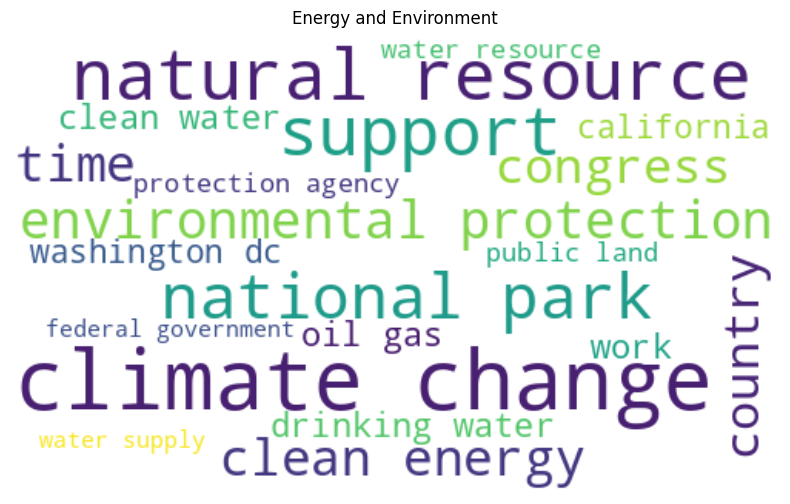

---
Education


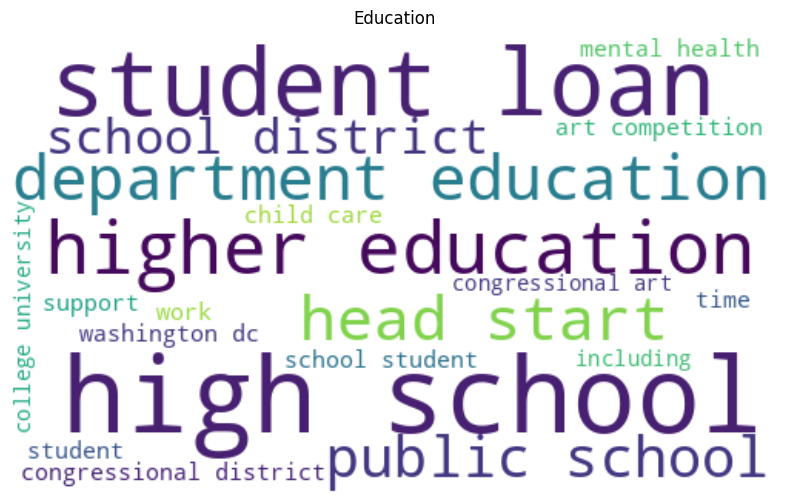

---
Health Care and Social Security


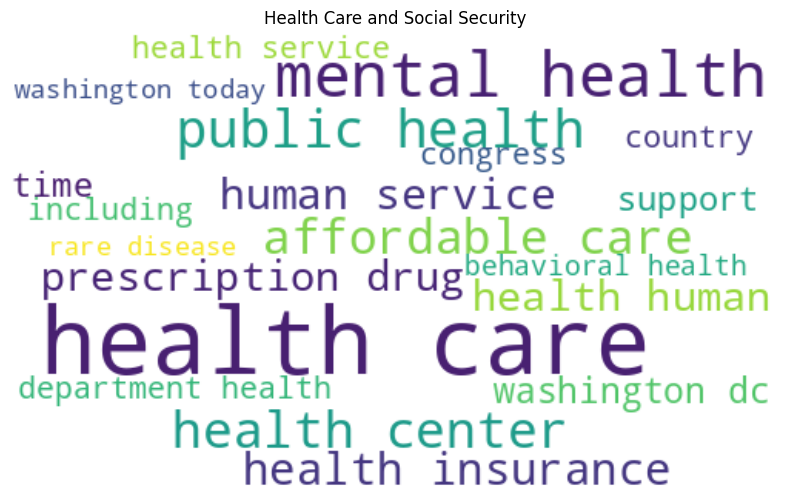

---
Jobs and the Economy


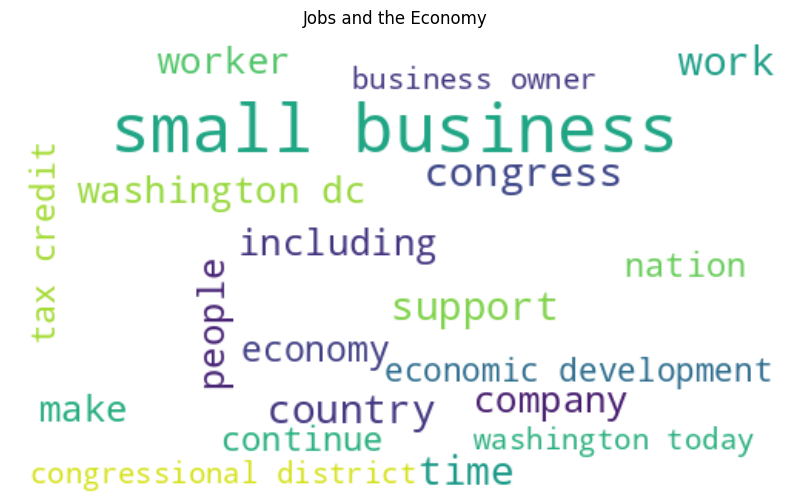

---
National Security, Defence, Foreign Affairs


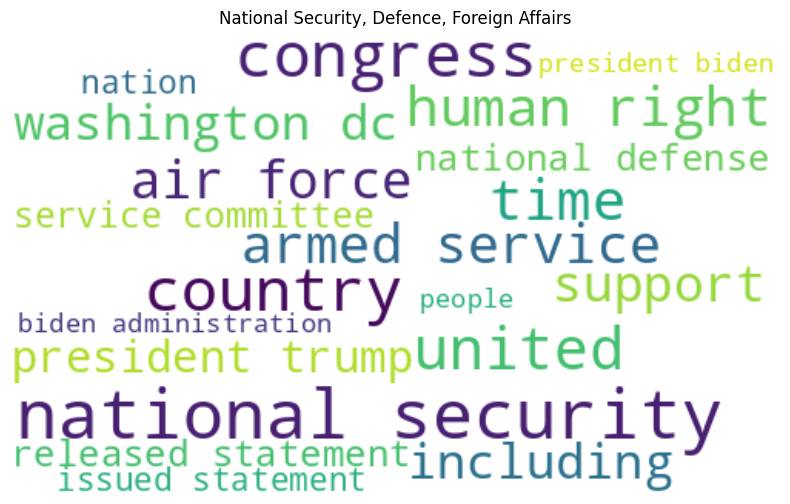

---
Veterans and Military


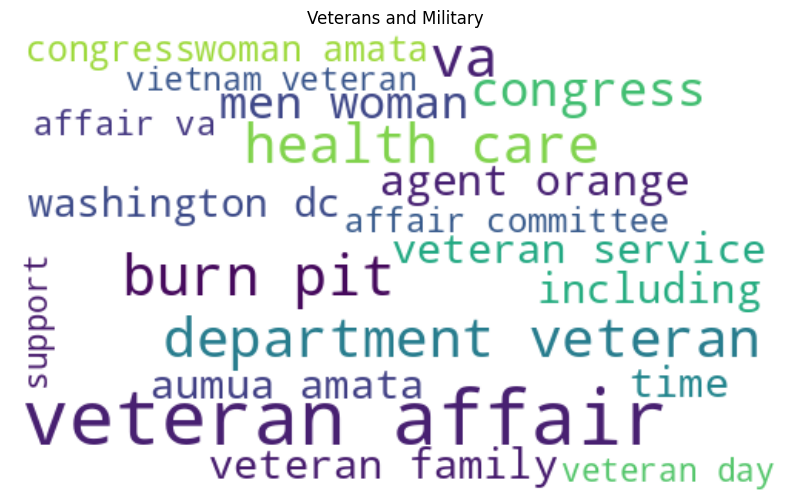

---
Government and Law


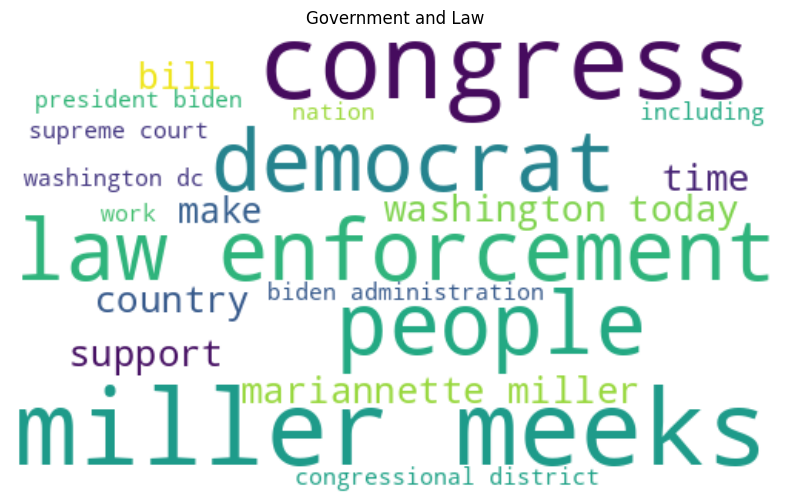

---


In [175]:
for issue in selected_issues:
	print(issue)
	issue_name = issue.replace(" ", "").replace(",", "")
	show_cloud(df_filtered[df_filtered["issue"]==issue]["text"], max_words=20, show=True, title=issue, save_name=f"word_clouds/word_cloud_{issue_name}.png")
	print("---")


## Training LDA

LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.
A topic is represented as a weighted list of words.

Since we’re going to use LDA for our document vectorization, we need to first train a sufficiently good LDA model to extract the best features possible of our data. To do so we need to find what is the optimal number of topics for our LDA model trained on this corpus. There are two strategies to tackle this problem:
- Grid search for different number of topics and evaluate each using a coherence metric. (Slow as a snail, and there are other parameters that need to tuned too, such as the number of words in the model’s dictionary.)
- An approach I read in a great Medium article, which utilized HDP (Hierarchical Dirichlet Process) to roughly estimate how many topics exist within our corpus.(Fast)

In [11]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

words = [nltk.word_tokenize(sentence) for sentence in df_filtered["text"].tolist()]
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(text) for text in words]
targets = df_filtered["issue"].to_list()

A common thing you will encounter with LDA is that words appear in multiple topics. One way to cope with this is to add these words to your stopwords list. 
Filtering words that appear in at least 3 (or more) documents is a good way to remove rare words that will not be relevant in topics.

In [12]:
num_topics=62
lda_model = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=num_topics, 
               passes=10, 
															random_state=42,
               iterations=100,
															per_word_topics=False)
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(lda_display, f"LDA_results_all_topics.html")
vis3 = pyLDAvis.display(lda_display)
vis3

In [74]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.asarray(df_filtered["text"].to_list())
y = np.asarray(df_filtered["issue"].to_list())
cv = StratifiedShuffleSplit(test_size=0.1, random_state=42)
for train_idx, test_idx in cv.split(X, y):
	X_train=X[train_idx]
	y_train=y[train_idx]
	X_test=X[test_idx]
	y_test=y[test_idx]

In [79]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models

words = [nltk.word_tokenize(sentence) for sentence in X_train.tolist()]
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(text) for text in words]

In [76]:
num_topics=7
lda_model = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=num_topics, 
															random_state=42,
															passes=10,
															iterations=80)
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)

In [77]:
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity)

Perplexity:  -8.11427334707278


We can use the coherence score in topic modeling to measure how interpretable the topics are to humans. In this case, topics are represented as the top N words with the highest probability of belonging to that particular topic. Briefly, the coherence score measures how similar these words are to each other.

One of the most popular coherence metrics is called CV. It creates content vectors of words using their co-occurrences and, after that, calculates the score using normalized pointwise mutual information (NPMI) and the cosine similarity. This metric is popular because it’s the default metric in the Gensim topic coherence pipeline module, but it has some issues. Even the author of this metric doesn’t recommend using it.

Instead of using the CV score, we recommend using the UMass coherence score. It calculates how often two words, w_{i} and w_{j} appear together in the corpus. As stated in the gensim documentation, the UMass is the fastest method to evaluate topic coherence. The best topic coherence is achieved when there are few documents containing a pair wi, wⱼ since each wᵢ represents a different topic. Looking at the UMass topic coherence definition, it means that the best topic coherence value is achieved when D(wᵢ) » D(wᵢ,wⱼ) for each i, j i.e. the best value corresponds to the topic coherence minimum.

In [27]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_UMass(model, corpus, dictionary):
   coherence = CoherenceModel(model=model,
                              corpus=corpus,
                              dictionary=dictionary,
                              coherence='u_mass')
   return coherence.get_coherence()

In [38]:
compute_coherence_UMass(lda_model, corpus, id2word)

-1.5236408002049961

In [82]:
num_topics=[5, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62]
scores = []
for nr_topics in num_topics:
	lda_model = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=nr_topics, 
															random_state=42,
															passes=10, 
															iterations=100)
	score = compute_coherence_UMass(lda_model, corpus, id2word)
	print(score)
	scores.append(score)

-1.3550742082195701
-1.4542884859561998
-1.9422477555111157
-1.703853916406648
-1.9300993407744025
-2.0566281571069833
-2.166883048560395
-2.3165074215246793
-2.373183369006106
-2.5321504545104085
-2.5831427616748917
-2.9027091373281895
-3.147305930373326


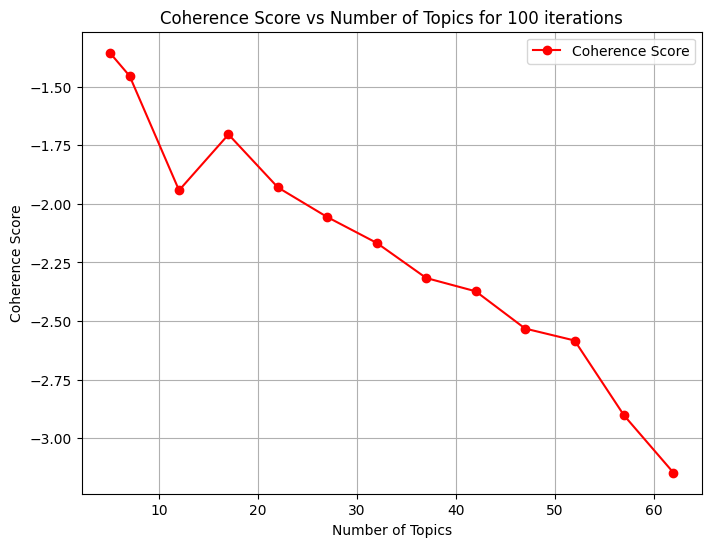

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(num_topics, scores, marker='o', linestyle='-', color='r', label='Coherence Score')

# Add labels and title
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs Number of Topics for 100 iterations')
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [84]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.display(lda_display)

In [ ]:
num_topics = 62
train_vecs = []
for i in range(len(X_train.tolist())):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(num_topics)]
    train_vecs.append(topic_vec)

In [39]:
for topic in lda_model.print_topics(num_topics=7, num_words=10):
    print(topic)

(0, '0.037*"health" + 0.024*"care" + 0.010*"service" + 0.009*"access" + 0.008*"patient" + 0.008*"bill" + 0.007*"drug" + 0.006*"cost" + 0.006*"legislation" + 0.006*"family"')
(1, '0.018*"defense" + 0.014*"military" + 0.013*"national" + 0.012*"force" + 0.011*"bill" + 0.009*"security" + 0.008*"support" + 0.008*"service" + 0.008*"courtney" + 0.008*"committee"')
(2, '0.012*"president" + 0.007*"congress" + 0.007*"trump" + 0.007*"people" + 0.006*"united" + 0.006*"administration" + 0.005*"republican" + 0.005*"security" + 0.005*"statement" + 0.005*"biden"')
(3, '0.016*"water" + 0.012*"project" + 0.010*"funding" + 0.008*"federal" + 0.008*"energy" + 0.007*"million" + 0.007*"infrastructure" + 0.007*"grant" + 0.006*"local" + 0.006*"county"')
(4, '0.016*"business" + 0.010*"small" + 0.006*"federal" + 0.006*"bill" + 0.006*"congresswoman" + 0.005*"administration" + 0.005*"legislation" + 0.005*"amata" + 0.005*"letter" + 0.005*"committee"')
(5, '0.017*"student" + 0.016*"school" + 0.010*"education" + 0.00

In [49]:
topics = {
    "Energy and Environment": 3, 
				"Education": 5, 
				"Health Care and Social Security": 0, 
				"Jobs and the Economy": 4,
				"National Security, Defence, Foreign Affairs": 1, 
				"Veterans and Military": 6, 
				"Government and Law": 2
}
    

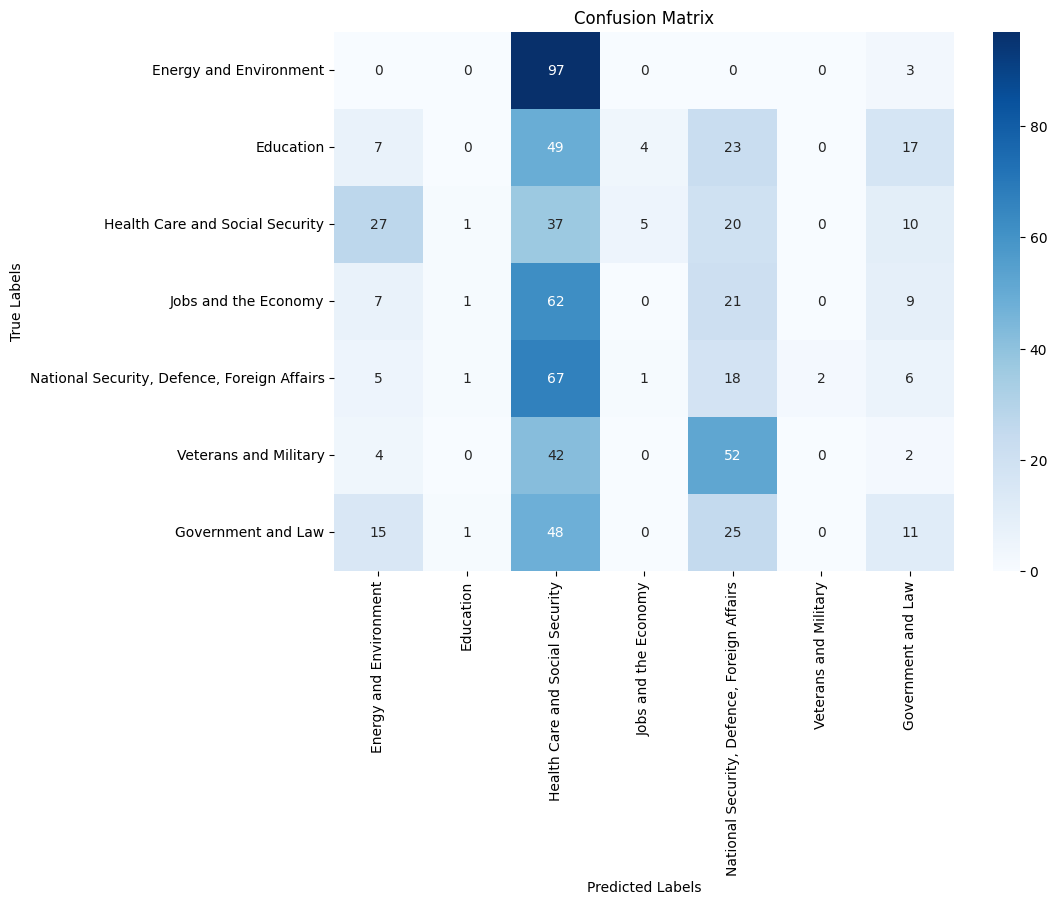

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

predictions = []
ground_truth = []
for x, y in zip(X_test, y_test):
    new_text_corpus =  id2word.doc2bow(x.split())
    predictions.append(lda_model[new_text_corpus][0][0])
    ground_truth.append(topics[y])

# Generate confusion matrix
cm = confusion_matrix(ground_truth, predictions, labels=list(topics.values()))

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=topics.keys(), 
            yticklabels=topics.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [53]:
label_counts = Counter(y_train)
for label, count in label_counts.items():
    print(f"{label}: {count}")

Energy and Environment: 2142
Government and Law: 913
Jobs and the Economy: 2100
Health Care and Social Security: 2637
National Security, Defence, Foreign Affairs: 3306
Education: 1270
Veterans and Military: 1238


----

### Preparing test data

In [48]:
df_cleaned = pd.read_csv("../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_multiple_issues = df_cleaned[df_cleaned['issue'].str.contains(';')]
df_multiple_issues

,issue,title,text
1,Jobs and the Economy;Agriculture,"""Ag Perspectives"" on KFRM 550AM Radio","It was great joining Kyle Baur on KFRM's ""Ag P..."
14,Local issues;Infrastructure and Transportation,$1.7 million to help turn old Bonner Springs g...,An additional $1.7 million was secured to deve...
15,Energy and Environment;Infrastructure and Tran...,$1.7M in omnibus bill will fund Oxford creek p...,WASHINGTON — President Joe Biden today was exp...
16,Jobs and the Economy;Education,$10M Grant to PNW for Steel Decarbonization Re...,Purdue University Northwest’s (PNW) Center for...
26,Equality and Civil Rights;Local issues,"$334,000 grant awarded to expand pro bono serv...",TOPEKA (KSNT) – A grant has been awarded to a ...
...,...,...,...
25622,Jobs and the Economy;Local issues,‘Punching above our weight’: KC requests $75M ...,Leaders of Kansas City’s Tech Hubs initiative ...
25623,"National Security, Defence, Foreign Affairs;He...",‘Put the food on our table every day’: Labor I...,The U.S. House under the leadership of Speaker...
25624,Veterans and Military;Health Care and Social S...,‘Sense Of Urgency’: Lawmakers Introduce Severa...,"Michigan Reps. Elissa Slotkin, a Democrat, and..."
25629,"National Security, Defence, Foreign Affairs;Jo...",‘We need a legislative fix’ for DACA: Full Rep...,"Chairman of the Congressional Hispanic Caucus,..."


In [41]:
df_test = pd.DataFrame(columns=["issue", "text"])
for _, row in df_multiple_issues.iterrows():
   issues = set(row['issue'].split(";"))
   if len(issues) == 1:
       print("sth went wrong")
       # issue = issues.pop()
       # if issue in selected_issues:
       #     df_test = df_test._append({"issue": issue, "text": row['text']}, ignore_index=True)
   else:
       if len(issues.intersection(set(selected_issues))) == 1:
               issue = issues.intersection(set(selected_issues)).pop()
               df_test = df_test._append({"issue": issue, "text": row['text']}, ignore_index=True)

In [42]:
import pandas as pd

# Example target number of articles per issue
target_count = 64  # Minimum count across issues

# Perform undersampling
df_balanced = (
    df_test
    .groupby("issue")
    .apply(lambda x: x.sample(n=target_count, random_state=42) if len(x) > target_count else x)
    .reset_index(drop=True)
)


/tmp/ipykernel_1699/4253897014.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=target_count, random_state=42) if len(x) > target_count else x)


In [43]:
df_balanced.groupby("issue").count()

,text
issue,
Education,64
Energy and Environment,64
Government and Law,64
Health Care and Social Security,64
Jobs and the Economy,64
"National Security, Defence, Foreign Affairs",64
Veterans and Military,64


In [44]:
topics = {
    "Energy and Environment": 2, 
				"Education": 4, 
				"Health Care and Social Security": 0, 
				"Jobs and the Economy": 5,
				"National Security, Defence, Foreign Affairs": 6, 
				"Veterans and Military": 3, 
				"Government and Law": 1
}
    

In [45]:
predictions = []
ground_truth = []
for _, row in df_test.iterrows():
    new_text_corpus =  id2word.doc2bow(row['text'].split())
    predictions.append(lda_model[new_text_corpus][0][0])
    ground_truth.append(topics[row['issue']])

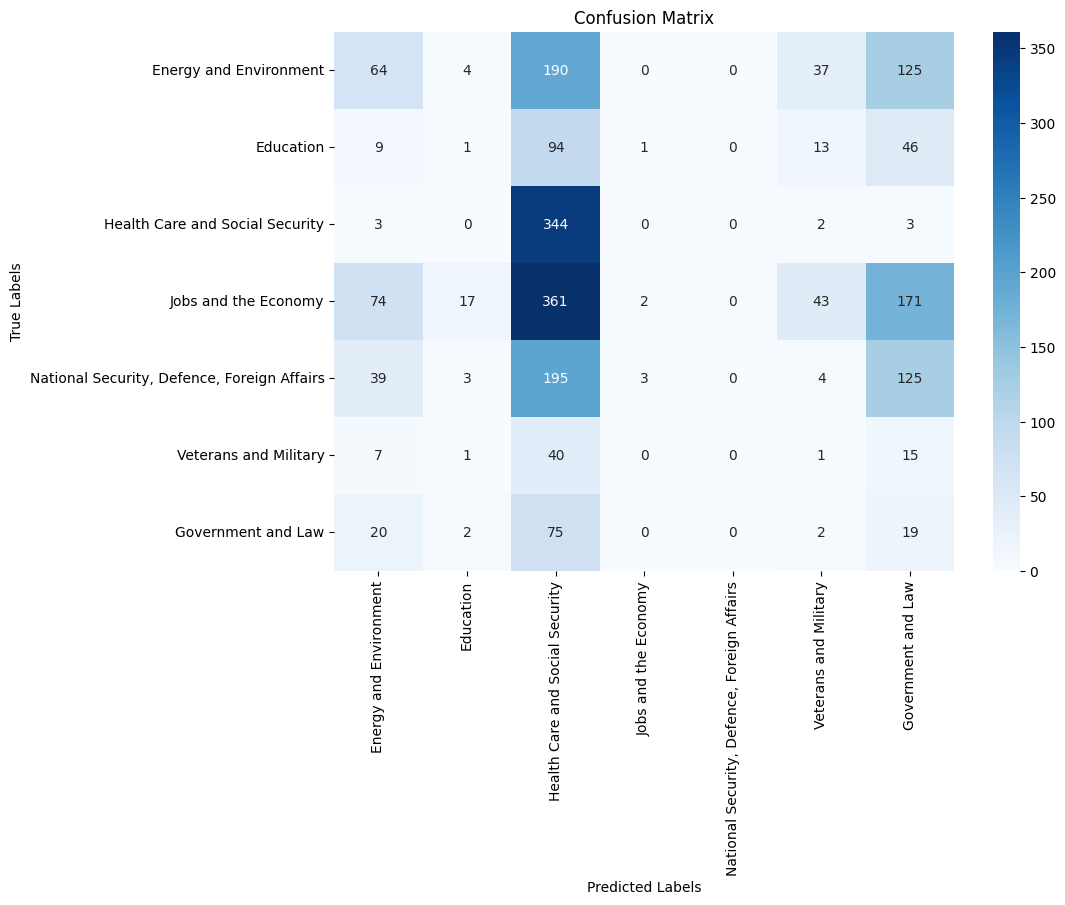

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(ground_truth, predictions, labels=list(topics.values()))

# Display confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=topics.keys(), 
            yticklabels=topics.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [47]:
from sklearn.metrics import classification_report
report = classification_report(ground_truth, predictions, target_names=topics.keys())
print(report)

                                             precision    recall  f1-score   support

                     Energy and Environment       0.26      0.98      0.42       352
                                  Education       0.04      0.16      0.06       118
            Health Care and Social Security       0.30      0.15      0.20       420
                       Jobs and the Economy       0.01      0.02      0.01        64
National Security, Defence, Foreign Affairs       0.04      0.01      0.01       164
                      Veterans and Military       0.33      0.00      0.01       668
                         Government and Law       0.00      0.00      0.00       369

                                   accuracy                           0.20      2155
                                  macro avg       0.14      0.19      0.10      2155
                               weighted avg       0.21      0.20      0.11      2155



/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/paulina/usa_issues_data_mining/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Converting Topics to Feature Vectors

Resources:
- https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
- https://gibbslda.sourceforge.net/fp224-phan.pdf